# <center> Predicting Flight Ticket Prices </center>

# Table of Contents:
* ## [Introduction](#introduction)

* ## [Scraped Data EDA](#eda)

* ## [Handling Categorical Data](#cat_data)

* ## [Features](#features)

* ## [Modeling](#modeling)

* ## [Saving The Final Model](#model)

## Introduction: <a class="anchor" id="introduction"></a>

<b> This is the main notebook for the BetterFly project. I predict ticket prices for upcoming flights in selecting the optimum time for travel and the cheapest flight to the desired destination.
The dataset used to train the models is scraped from [Kayak](http://www.kayak.com) which is detailed in the scraper notebook. </b>

### Importing necessarry libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics

## Scraped Data EDA: <a class="anchor" id="eda"></a>
### Loading the scraped data

In [3]:
df_1 = pd.read_csv("dataset/AMS_NYC.csv")
df_2 = pd.read_csv("dataset/FCO_NYC.csv")
df_3 = pd.read_csv("dataset/MEX_PAR.csv")
df_4 = pd.read_csv("dataset/NYC_AMS.csv")
df_5 = pd.read_csv("dataset/NYC_LUX.csv")
df_6 = pd.read_csv("dataset/NYC_PAR.csv")
df_7 = pd.read_csv("dataset/PAR_NYC.csv")
df_8 = pd.read_csv("dataset/TLV_BKK.csv")
df_9 = pd.read_csv("dataset/TLV_GRU.csv")
df_10 = pd.read_csv("dataset/TLV_MEX.csv")
df_11 = pd.read_csv("dataset/TLV_OSL.csv")
df_12 = pd.read_csv("dataset/YYZ_BKK.csv")

In [4]:
print(f"{df_1['Source'][0]} ---> {df_1['Destination'][0]} route has {df_1.shape[0]} trips")
print(f"{df_2['Source'][0]} ---> {df_2['Destination'][0]} route has {df_2.shape[0]} trips")
print(f"{df_3['Source'][0]} ---> {df_3['Destination'][0]} route has {df_3.shape[0]} trips")
print(f"{df_4['Source'][0]} ---> {df_4['Destination'][0]} route has {df_4.shape[0]} trips")
print(f"{df_5['Source'][0]} ---> {df_5['Destination'][0]} route has {df_5.shape[0]} trips")
print(f"{df_6['Source'][0]} ---> {df_6['Destination'][0]} route has {df_6.shape[0]} trips")
print(f"{df_7['Source'][0]} ---> {df_7['Destination'][0]} route has {df_7.shape[0]} trips")
print(f"{df_8['Source'][0]} ---> {df_8['Destination'][0]} route has {df_8.shape[0]} trips")
print(f"{df_9['Source'][0]} ---> {df_9['Destination'][0]} route has {df_9.shape[0]} trips")
print(f"{df_10['Source'][0]} ---> {df_10['Destination'][0]} route has {df_10.shape[0]} trips")
print(f"{df_11['Source'][0]} ---> {df_11['Destination'][0]} route has {df_11.shape[0]} trips")
print(f"{df_12['Source'][0]} ---> {df_12['Destination'][0]} route has {df_12.shape[0]} trips")

AMS ---> NYC route has 4202 trips
FCO ---> NYC route has 7279 trips
MEX ---> PAR route has 2725 trips
NYC ---> AMS route has 3205 trips
NYC ---> LUX route has 1905 trips
NYC ---> PAR route has 7327 trips
NYC ---> PAR route has 14881 trips
TLV ---> BKK route has 553 trips
TLV ---> GRU route has 2235 trips
TLV ---> MEX route has 3314 trips
TLV ---> OSL route has 5334 trips
YYZ ---> BKK route has 2403 trips


### Defining functions to clean the data

In [62]:
# convert the duration from hour and minute to minute
def clean_duration(duration):
    d = []
    for dur in duration:
        if isinstance(dur, str):
            hours = 0
            mins = 0
            if 'h' in dur:
                hours = int(dur.split('h')[0])
            if 'm' in dur:
                mins = int(dur.split('h')[-1].split('m')[0].strip())
            d.append(hours * 60 + mins)
        elif isinstance(dur, int):
            d.append(dur)
        else:
            print(f"Warning: Unexpected value in duration column: {dur}")
    return d

# convert price to numerical format in USD
def clean_price(price):
    price = price.astype(str)
    price = price.str.replace(',','',regex=True)
    price = price.str.replace('NIS','',regex=True)
    price = price.str.replace('Â','',regex=True)
    price = price.str.strip()
    price = price.replace('nan', np.nan)
    price = round(pd.to_numeric(price)/3.75,2)
    return price

# convert date to datetime format
def clean_date(date):
    date = pd.to_datetime(date, format='%d/%m/%Y', errors='coerce')
    return date

# get price quantile to deal with outliers
def get_price_quantile(price):
    Q1 = price.quantile(0.25)
    Q3 = price.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    return (lower_lim,upper_lim)

# get average of each airline
def get_avg_per_airline(x):
    # average for trips with multiple airlines
    multiple_airlines = x[x["Airline"].str.contains(",")]
    b = list(multiple_airlines["Airline"].str.split(","))
    d = [] # Airline 1
    e = [] # Airline 2
    for i in range(len(b)):
        d.append(b[i][0])
        e.append(b[i][1])
    for i in range(len(e)):
        e[i] = e[i].strip()
    m_airlines = list(set(d)) + list(set(e))
    column_names = ["Airline", "Average Price"]
    t_ = pd.DataFrame(columns = column_names)
    for airline in m_airlines:
        t = pd.DataFrame(x[x["Airline"].str.contains(airline)]["Airline"])
        t["Average Price"] = x[x["Airline"].str.contains(airline)]["Price"].mean()
        t_ = t_.append(t)
    t__ = t_.groupby("Airline",as_index = False)["Average Price"].mean()
    k = multiple_airlines.copy()
    k = k.merge(t__, on = "Airline", how = "left")
    
    # average for trips with single airlines
    single_airlines = x[~x["Airline"].str.contains(",")]
    avg_per_airline = single_airlines.groupby("Airline", as_index = False)["Price"].mean()
    avg_per_airline = avg_per_airline.rename(columns={"Price" : "Average Price"})
    temp = single_airlines.copy()
    temp = temp.merge(avg_per_airline, on='Airline', how ="left")
    
    temp_1 = temp.groupby("Airline", as_index = False)["Average Price"].mean()
    k_1 = k.groupby("Airline", as_index = False)["Average Price"].mean()
    k_temp = pd.concat([k_1,temp_1])
    y = x.merge(k_temp, on = "Airline")
    
    return y



In [6]:
dfs_raw = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12]

In [7]:
# cleaning the data
dfs = []
for df in dfs_raw:
    df.drop_duplicates() # drop duplicate rows
    df["Duration"] = clean_duration(df["Duration"]) # convert duration to numerical minutes format
    df["Price"] = clean_price(df["Price"]) # convert price to numerical format in USD
    df["Date"] = clean_date(df["Date"]) # convert date to datetime format
    dfs.append(get_avg_per_airline(df)) # get average per airline

C:\Users\Slagter\AppData\Local\Temp\ipykernel_13756\1492048629.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_ = t_.append(t)
C:\Users\Slagter\AppData\Local\Temp\ipykernel_13756\1492048629.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_ = t_.append(t)
C:\Users\Slagter\AppData\Local\Temp\ipykernel_13756\1492048629.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_ = t_.append(t)
C:\Users\Slagter\AppData\Local\Temp\ipykernel_13756\1492048629.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_ = t_.append(t)
C:\Users\Slagter\AppData\Local\Temp\ipykernel_13756\1492048629.py:76: FutureWarning: The frame.append method

### Studying outliers

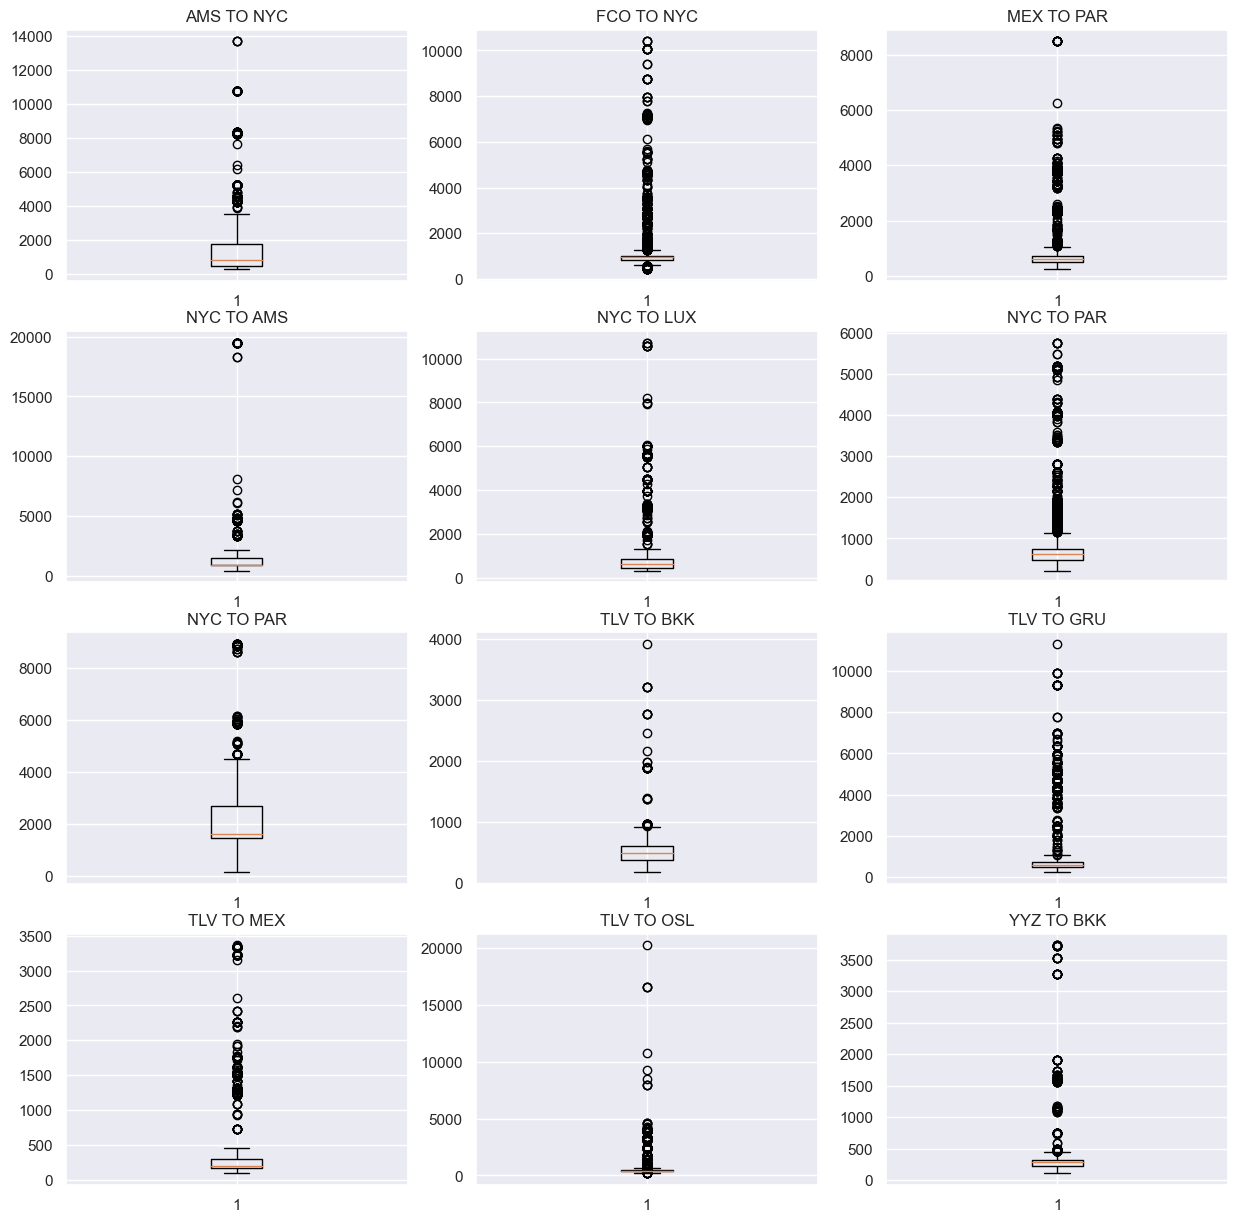

In [8]:
# boxplots for each route
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### It is apparent that all routes have outliers, so we'll deal with them by IQR

In [9]:
# get quantile to deal with outliers
lower = []
upper = []
for df in dfs:
    x = get_price_quantile(df['Price'])
    lower.append(x[0])
    upper.append(x[1])

In [10]:
# drop outliers
k = 0
for df in dfs:
    low = df['Price'] < lower[k]
    up = df['Price'] > upper[k]
    df['Price'] = df['Price'][~(low|up)]
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace=True)
    k+=1

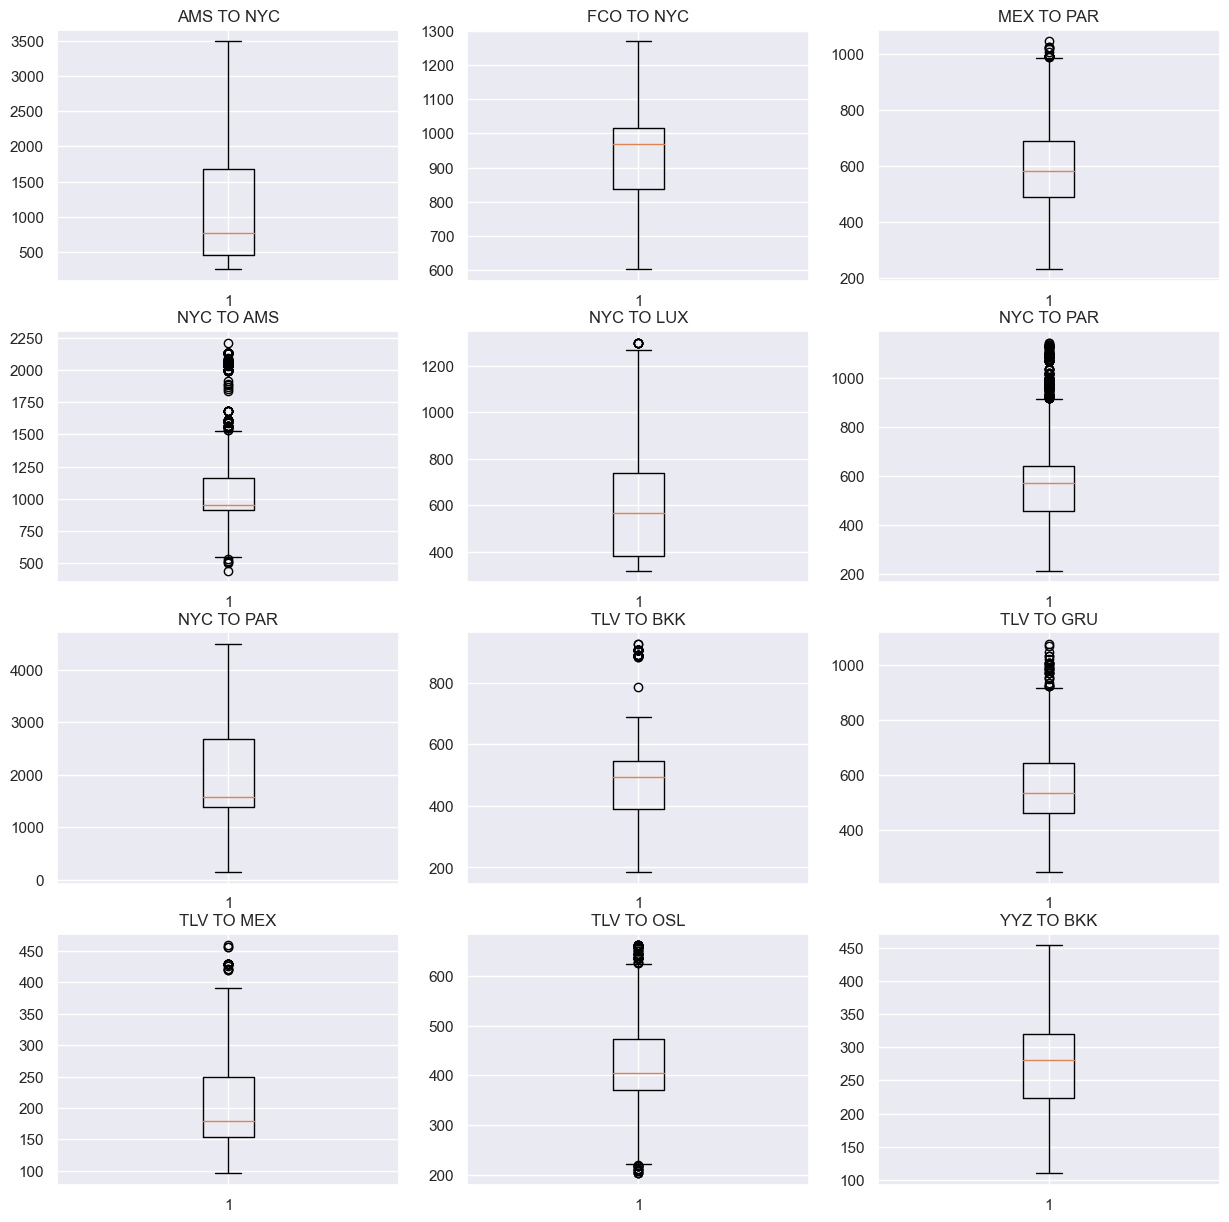

In [11]:
# boxplot for each route after dealing with outliers
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### Now the data is much better, the total dropped data is 5,266 rows out of 55,363.

In [12]:
# concat all routes into one dataframe
df = pd.concat(dfs)
df

,Airline,Source,Destination,Duration,Total stops,Price,Date,Average Price
0,Aeroflot,AMS,NYC,615,nonstop,265.07,2023-03-01,254.677541
1,Aeroflot,AMS,NYC,615,nonstop,247.73,2023-03-01,254.677541
2,Aeroflot,AMS,NYC,615,nonstop,247.73,2023-03-01,254.677541
3,Aeroflot,AMS,NYC,615,nonstop,265.07,2023-03-02,254.677541
4,Aeroflot,AMS,NYC,615,nonstop,247.73,2023-03-02,254.677541
...,...,...,...,...,...,...,...,...
2174,"Air France, airBaltic",YYZ,BKK,655,3 stops,295.73,2023-04-09,283.559226
2175,"Air France, Pobeda",YYZ,BKK,400,1 stop,286.67,2023-04-03,273.818786
2176,"Transavia France, Finnair",YYZ,BKK,695,2 stops,202.13,2023-04-05,215.548002
2177,"Norwegian, LOT",YYZ,BKK,825,2 stops,192.53,2023-04-09,251.441247


In [13]:
# check for null values
df.isnull().sum()

Airline          0
Source           0
Destination      0
Duration         0
Total stops      0
Price            0
Date             0
Average Price    0
dtype: int64

## Handling Categorical Data: <a class="anchor" id="cat_data"></a>


In [14]:
# the Airline column will be replaced by the average price per airline.
df.drop("Airline", axis = 1, inplace = True)

In [15]:
# source
df["Source"].value_counts()

NYC    24943
TLV     9836
FCO     6108
AMS     3813
MEX     2301
YYZ     2179
Name: Source, dtype: int64

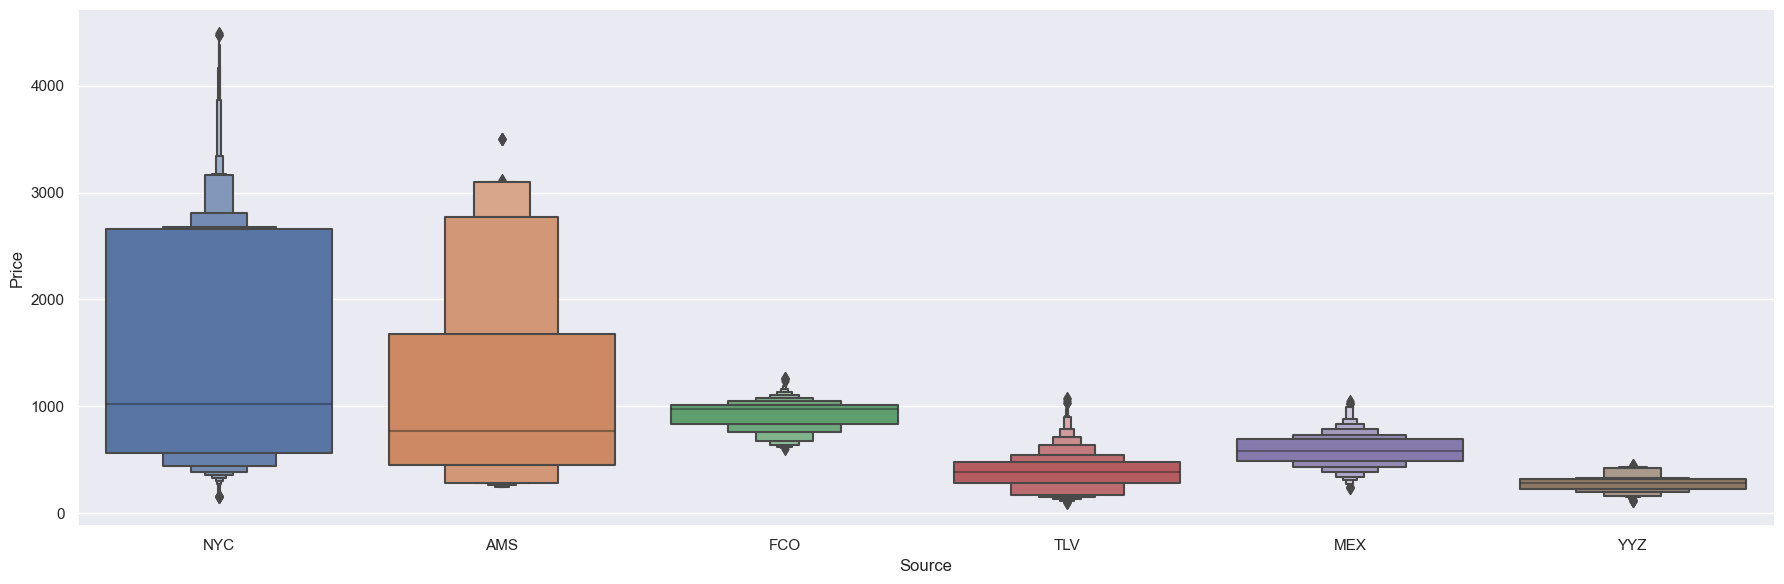

In [16]:
# source vs price
sns.catplot(y = "Price", x= "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [17]:
# performing OneHotEncoding on Source since it's nominal categorical data  
source =df[["Source"]]
source =pd.get_dummies(source, drop_first=True)
source.head()

,Source_FCO,Source_MEX,Source_NYC,Source_TLV,Source_YYZ
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [18]:
# destination
df["Destination"].value_counts()

PAR    22627
NYC     9921
OSL     4781
AMS     3051
MEX     2689
BKK     2673
GRU     1872
LUX     1566
Name: Destination, dtype: int64

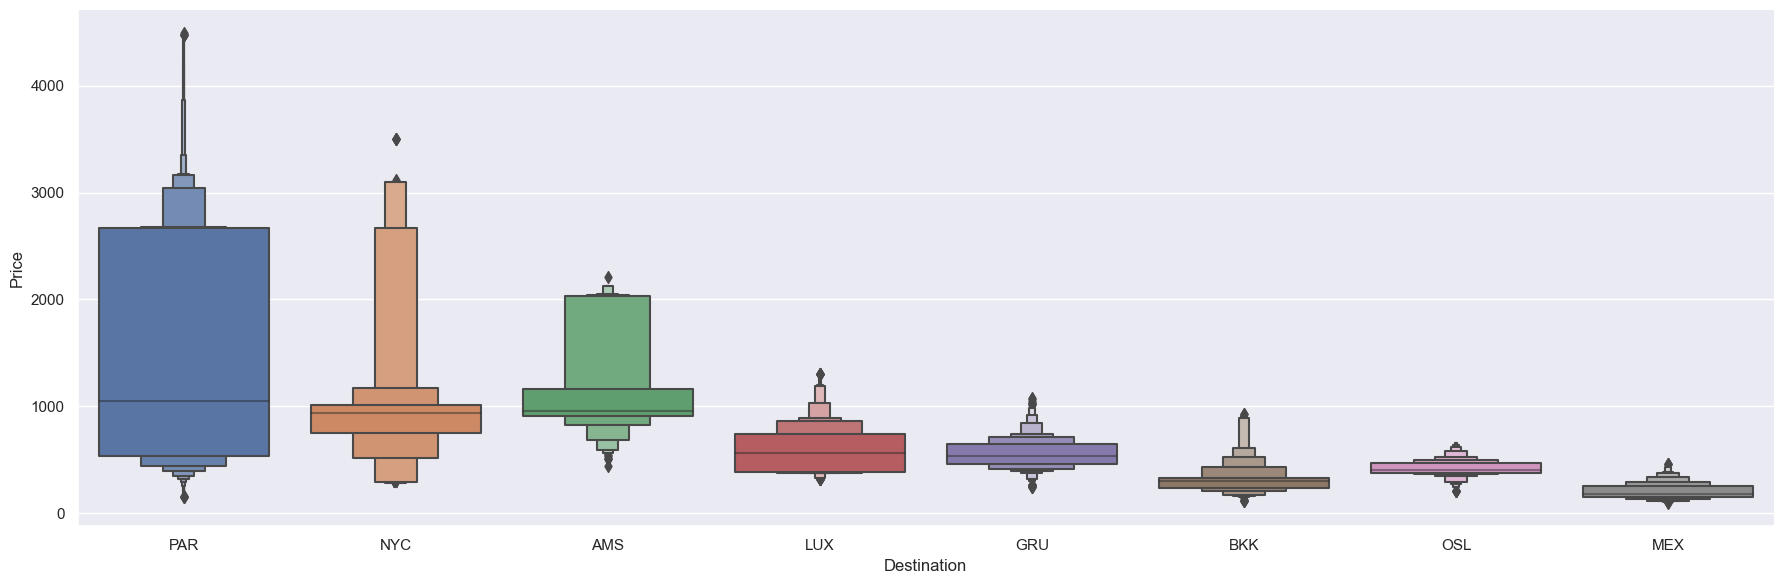

In [19]:
# destination vs price
sns.catplot(y = "Price", x= "Destination", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [20]:
# performing OneHotEncoding on Destination since it's nominal categorical data
destination = df[["Destination"]]
destination = pd.get_dummies(destination, drop_first=True)
destination.head()

,Destination_BKK,Destination_GRU,Destination_LUX,Destination_MEX,Destination_NYC,Destination_OSL,Destination_PAR
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [21]:
# total stops
print(df["Total stops"].value_counts())
df["Total stops"].unique()

1 stop      26963
2 stops     18318
nonstop      1951
3 stops      1948
Name: Total stops, dtype: int64


array(['nonstop ', '1 stop ', '2 stops ', '3 stops '], dtype=object)

In [22]:
# performing LabelEncoder on Total stops since it's ordinal categorical data
df.replace({"nonstop ":0, "1 stop ": 1, "2 stops ": 2, "3 stops ":3}, inplace=True)

In [23]:
final_df = pd.concat([df,source,destination], axis=1).reset_index(drop = True)

In [24]:
final_df

,Source,Destination,Duration,Total stops,Price,Date,Average Price,Source_FCO,Source_MEX,Source_NYC,Source_TLV,Source_YYZ,Destination_BKK,Destination_GRU,Destination_LUX,Destination_MEX,Destination_NYC,Destination_OSL,Destination_PAR
0,AMS,NYC,615,0,265.07,2023-03-01,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
1,AMS,NYC,615,0,247.73,2023-03-01,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
2,AMS,NYC,615,0,247.73,2023-03-01,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
3,AMS,NYC,615,0,265.07,2023-03-02,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
4,AMS,NYC,615,0,247.73,2023-03-02,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49175,YYZ,BKK,655,3,295.73,2023-04-09,283.559226,0,0,0,0,1,1,0,0,0,0,0,0
49176,YYZ,BKK,400,1,286.67,2023-04-03,273.818786,0,0,0,0,1,1,0,0,0,0,0,0
49177,YYZ,BKK,695,2,202.13,2023-04-05,215.548002,0,0,0,0,1,1,0,0,0,0,0,0
49178,YYZ,BKK,825,2,192.53,2023-04-09,251.441247,0,0,0,0,1,1,0,0,0,0,0,0


In [25]:
# drop date since it'll not be used as a feature
final_df.drop(["Source","Destination","Date"], axis=1, inplace=True)

In [26]:
final_df

,Duration,Total stops,Price,Average Price,Source_FCO,Source_MEX,Source_NYC,Source_TLV,Source_YYZ,Destination_BKK,Destination_GRU,Destination_LUX,Destination_MEX,Destination_NYC,Destination_OSL,Destination_PAR
0,615,0,265.07,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
1,615,0,247.73,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
2,615,0,247.73,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
3,615,0,265.07,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
4,615,0,247.73,254.677541,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49175,655,3,295.73,283.559226,0,0,0,0,1,1,0,0,0,0,0,0
49176,400,1,286.67,273.818786,0,0,0,0,1,1,0,0,0,0,0,0
49177,695,2,202.13,215.548002,0,0,0,0,1,1,0,0,0,0,0,0
49178,825,2,192.53,251.441247,0,0,0,0,1,1,0,0,0,0,0,0


In [27]:
final_df.shape

(49180, 16)

In [28]:
final_df.isnull().sum()

Duration           0
Total stops        0
Price              0
Average Price      0
Source_FCO         0
Source_MEX         0
Source_NYC         0
Source_TLV         0
Source_YYZ         0
Destination_BKK    0
Destination_GRU    0
Destination_LUX    0
Destination_MEX    0
Destination_NYC    0
Destination_OSL    0
Destination_PAR    0
dtype: int64

## Features: <a class="anchor" id="features"></a>

#### After constructing the final dataframe with all numerical values, now we can analyze the features that will be used for the regressions models

In [29]:
final_df.columns

Index(['Duration', 'Total stops', 'Price', 'Average Price', 'Source_FCO',
       'Source_MEX', 'Source_NYC', 'Source_TLV', 'Source_YYZ',
       'Destination_BKK', 'Destination_GRU', 'Destination_LUX',
       'Destination_MEX', 'Destination_NYC', 'Destination_OSL',
       'Destination_PAR'],
      dtype='object')

In [30]:
X = final_df[['Duration', 'Total stops', 'Price', 'Average Price', 'Source_FCO',
       'Source_MEX', 'Source_NYC', 'Source_TLV', 'Source_YYZ',
       'Destination_BKK', 'Destination_GRU', 'Destination_LUX',
       'Destination_MEX', 'Destination_NYC', 'Destination_OSL',
       'Destination_PAR']]

y = final_df["Price"]

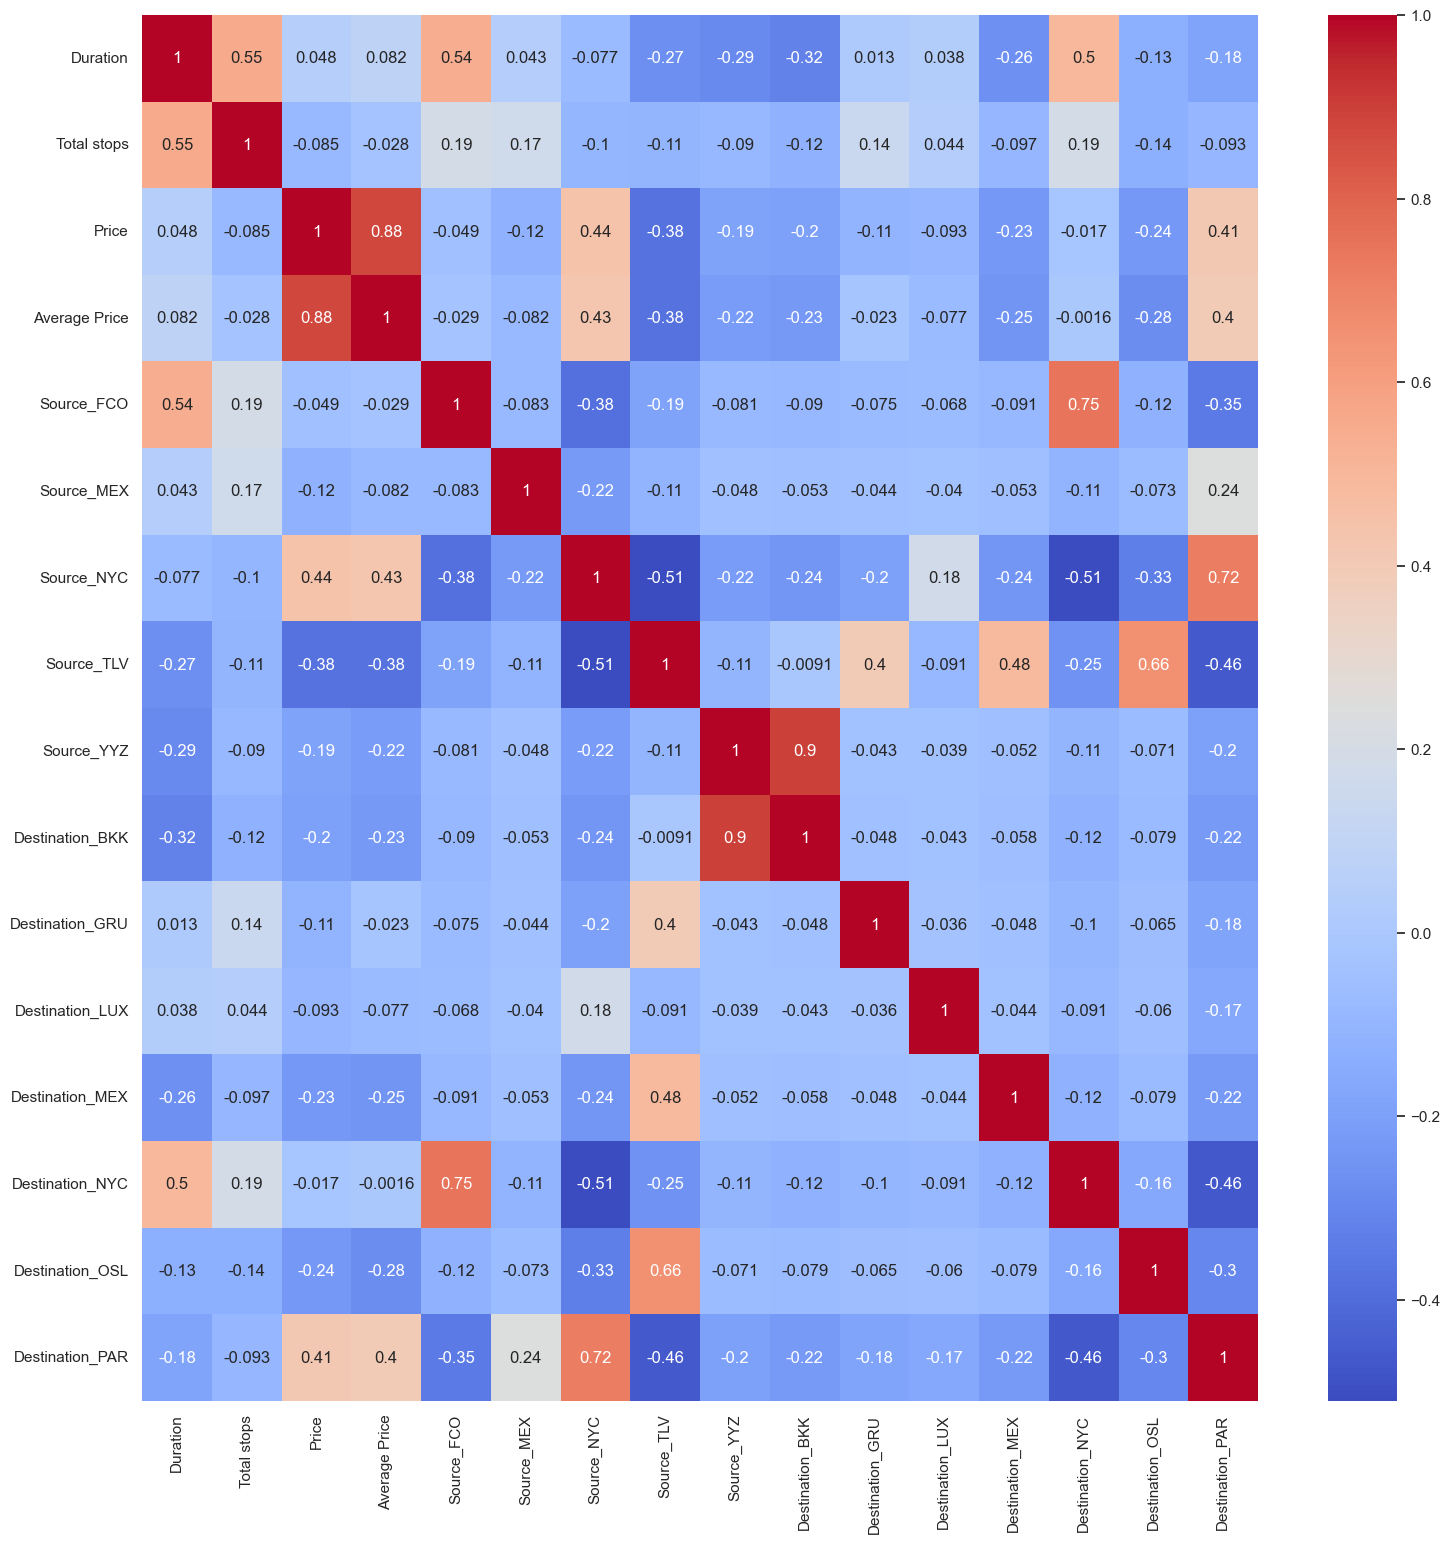

In [31]:
plt.figure(figsize = (18,18))

sns.heatmap(final_df.corr(),annot= True, cmap = "coolwarm")

plt.show()

In [32]:
# getting feature importance to the target variable "Price".
selection =ExtraTreesRegressor()
selection.fit(X,y)
selection.feature_importances_

array([1.49604360e-04, 6.54505657e-04, 6.61453002e-01, 2.62982719e-01,
       5.27608852e-03, 7.34966826e-06, 4.79006490e-02, 4.80360353e-03,
       7.77075259e-04, 4.08196418e-04, 1.12944447e-03, 2.74187708e-04,
       1.94119134e-03, 5.75588507e-03, 1.62502185e-04, 6.32399669e-03])

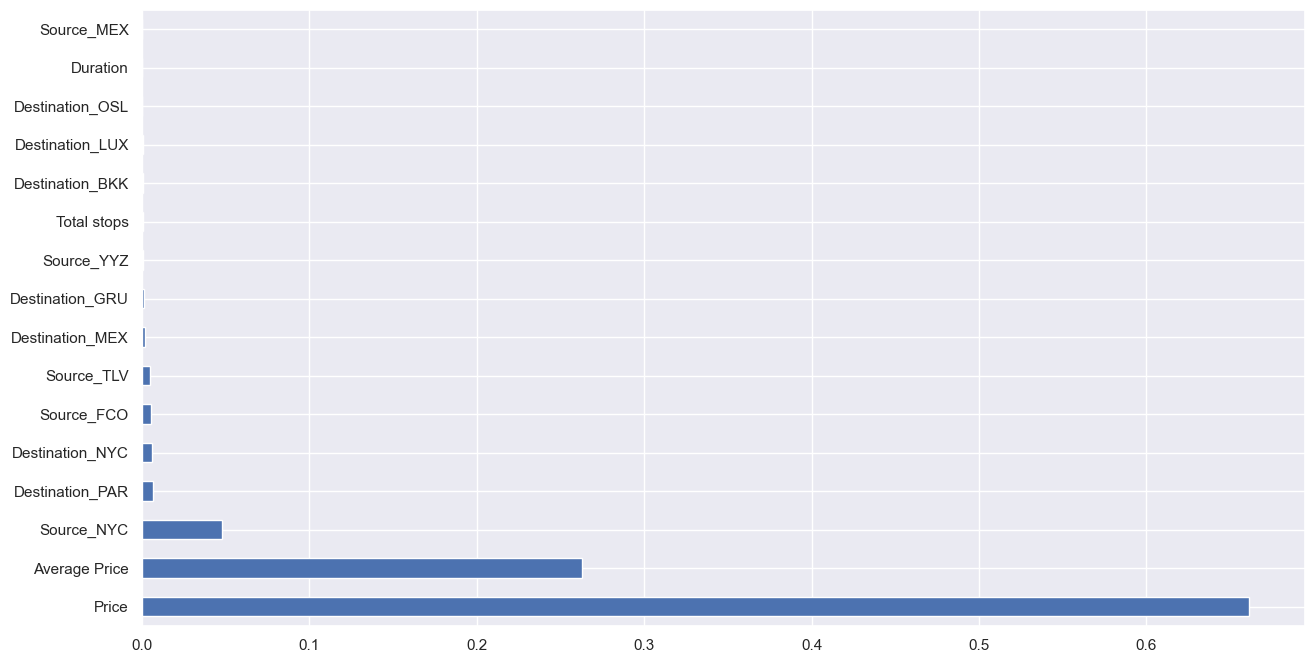

In [64]:
# plotting graph of important features
plt.figure(figsize = (15,8))
feat_importances = pd.Series(selection.feature_importances_,index = X.columns)
feat_importances.nlargest(50000).plot(kind="barh")
plt.show()

## Modeling: <a class="anchor" id="modeling"></a>

### Splitting the data

In [34]:
# 60% Train - 20% Val - 20% Test

X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)

### Defining a function to get metrics for val set

In [35]:
def get_metrics(model):
    print(f'Train score {model.score(X_train, y_train)}')
    print(f'Val score {model.score(X_val, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val))))

### Baseline Linear Regression

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
score = lr.score(X_val, y_val)
get_metrics(lr)

Train score 1.0
Val score 1.0
MAE: 3.7914779986697856e-13
MSE: 2.5387335564979006e-25
RMSE: 5.038584678754442e-13


### Polynomial 

In [37]:
for degree in [1,2,3,4]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("-"*20)
    print("Degree", degree)
    get_metrics(poly)

--------------------
Degree 1
Train score 1.0
Val score 1.0
MAE: 3.2394176447071764e-11
MSE: 1.0494610252852268e-21
RMSE: 3.2395385864120015e-11
--------------------
Degree 2
Train score 1.0
Val score 1.0
MAE: 3.557284991177076e-10
MSE: 2.7248868445773156e-19
RMSE: 5.220044870091938e-10
--------------------
Degree 3
Train score 1.0
Val score 1.0
MAE: 3.1544748259172707e-06
MSE: 1.7581346245484087e-11
RMSE: 4.193011596154259e-06
--------------------
Degree 4
Train score 0.9999999828022356
Val score 0.9999999599119815
MAE: 0.07128689026596528
MSE: 0.029667982528770957
RMSE: 0.1722439622418474


### Lasso

In [38]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
get_metrics(lasso_model)

Train score 0.999999991081006
Val score 0.9999999913309661
MAE: 0.045425649345068056
MSE: 0.006415701180506641
RMSE: 0.08009807226460972


### Ridge

In [39]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
get_metrics(ridge_model)

Train score 1.0
Val score 1.0
MAE: 4.9933949736535014e-08
MSE: 7.405646581015103e-15
RMSE: 8.60560664974591e-08


### ElasticNet

In [40]:
EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train, y_train)
EN_model.score(X_val, y_val)
get_metrics(EN_model)

Train score 0.9999999864541418
Val score 0.9999999868332685
MAE: 0.0558275655551237
MSE: 0.009744316956500644
RMSE: 0.09871330688666369


### Random Forest

In [41]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
get_metrics(rf)

Train score 0.9999997575168342
Val score 0.9999989641665523
MAE: 0.0521771553487507
MSE: 0.7665903630305793
RMSE: 0.8755514622399869


### Feature Scaling

In [42]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [43]:
# function to get metrics for scaled features
def scaled_metrics(model):
    print(f'Train score {model.score(X_train_scaled, y_train)}')
    print(f'Val score {model.score(X_val_scaled, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val_scaled)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val_scaled)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val_scaled))))

    
## Baseline: Linear Regression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
score = lr.score(X_val_scaled, y_val)
print("LR")
scaled_metrics(lr)
print("-"*50)

## Polynomial

for degree in [1,2,3,4]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("Polynomial - Degree", degree)
    scaled_metrics(poly)
    print("-"*50)

## Lasso

lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
print("Lasso")
scaled_metrics(lasso_model)
print("-"*50)

## Ridge

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
print("Ridge")
scaled_metrics(ridge_model)
print("-"*50)

## ElasticNet

EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train_scaled, y_train)
EN_model.score(X_val_scaled, y_val)
print("ElasticNet")
scaled_metrics(EN_model)
print("-"*50)

## Random Forest
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print("Random Forest")
scaled_metrics(rf)

LR
Train score 1.0
Val score 1.0
MAE: 4.902542607564117e-13
MSE: 3.991411000570173e-25
RMSE: 6.3177614710989e-13
--------------------------------------------------
Polynomial - Degree 1
Train score -1.45931296356652
Val score -1.4768099946604636
MAE: 1046.2635068752352
MSE: 1833015.4110667892
RMSE: 1353.888995105134
--------------------------------------------------


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Polynomial - Degree 2
Train score -1.4600300016289807
Val score -1.4775330755632932
MAE: 1046.3264228299456
MSE: 1833550.5423207777
RMSE: 1354.0866081313918
--------------------------------------------------


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Polynomial - Degree 3


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Train score -1.4599239356014269
Val score -1.4774084546432036


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


MAE: 1046.7118101790707
MSE: 1833458.3139837


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


RMSE: 1354.0525521499155
--------------------------------------------------
Polynomial - Degree 4


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Train score -1.4719515781019648


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Val score -1.4894182586432776


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


MAE: 1052.0223179020643


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


MSE: 1842346.422422977


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


RMSE: 1357.3306238433497
--------------------------------------------------
Lasso
Train score 0.9999986433756746
Val score 0.9999986432497155
MAE: 0.7840684786642179
MSE: 1.004091628260976
RMSE: 1.0020437257230723
--------------------------------------------------
Ridge
Train score 0.9999999944837507
Val score 0.9999999945654606
MAE: 0.036800688839762515
MSE: 0.004021945336236322
RMSE: 0.06341880900991693
--------------------------------------------------
ElasticNet
Train score 0.9167583976660549
Val score 0.9176002217194924
MAE: 169.47196135961545
MSE: 60981.69168497823
RMSE: 246.94471382270612
--------------------------------------------------
Random Forest
Train score -1.1903702479780724
Val score -1.2067064115007176


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


MAE: 945.0344922224483
MSE: 1633119.5645611929
RMSE: 1277.935665266915


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


#### Feature scaling was of no use, it did not improve anything.



**<br>From the above analysis, we can see that the random forest model performed the best with:</br>**

**Train score 0.9648778537711422**
**<br>Val score 0.9448134490695079</br>**
**<br>MAE: 61.717733027545194</br>**
**<br>MSE: 40035.31608101726</br>**
**<br>RMSE: 200.0882707232417</br>**

**So, we'll select it as our model.**

In [44]:
# retraining the random forest model on train + val, and scoring on test

X_train_val = pd.concat([X_train,X_val])
y_train_val = pd.concat([y_train,y_val])

rf = RandomForestRegressor()
rf.fit(X_train_val,y_train_val)

print(f'Train score {rf.score(X_train_val, y_train_val)}')
print(f'Test score {rf.score(X_test, y_test)}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf.predict(X_test))))

Train score 0.9999997973366753
Test score 0.999999302092784
MAE: 0.04496383692667145
MSE: 0.5105684421828558
RMSE: 0.7145407211509053


In [45]:
y_train_val_pred = rf.predict(X_train_val)
y_test_pred = rf.predict(X_test)

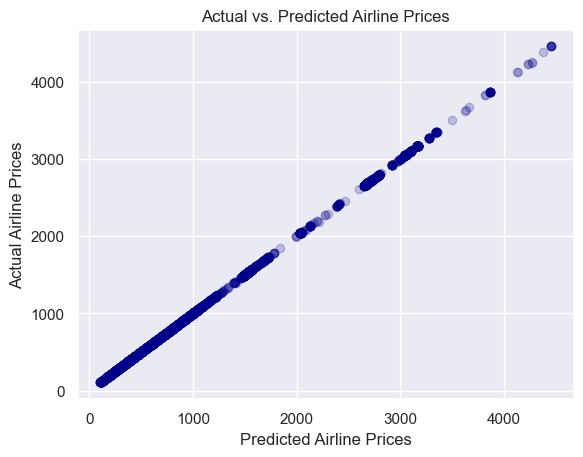

In [46]:
plt.scatter(y_test,y_test_pred,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

### Hyperparameter Tuning

In [47]:
# randomized search CV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [48]:
# create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [49]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, n_jobs = 1)

In [50]:
rf_random.fit(X_train_val,y_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=  36.2s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=  41.0s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=  34.1s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=  35.5s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=  36.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   6.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   6.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   6.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   5.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   6.5s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=700; total time=  36.0s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=700; total time=  37.0s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=700; total time=  35.3s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=700; total time=  37.2s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=700; total time=  36.4s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  49.5s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  51.8s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  49.8s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  49.1s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  48.5s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=  56.8s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=  57.8s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=  56.9s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=  57.7s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=  59.7s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, n_estimators=1000; total time=  23.0s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, n_estimators=1000; total time=  27.3s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, n_estimators=1000; total time=  26.3s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, n_estimators=1000; total time=  26.6s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, n_estimators=1000; total time=  27.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=1100; total time=  18.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=1100; total time=  19.5s
[CV] END max_dep

c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.7s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.7s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.7s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.9s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1100; total time=  26.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1100; total time=  26.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1100; total time=  26.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1100; total time=  28.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1100; total time=  26.9s


c:\Users\Slagter\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [51]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 20}

In [52]:
prediction = rf_random.predict(X_test)

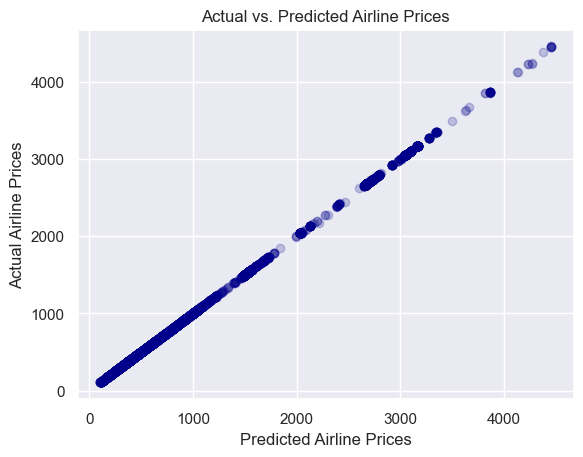

In [53]:
plt.scatter(y_test,prediction,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

In [54]:
print("MAE:" , metrics.mean_absolute_error(y_test,prediction))
print("MSE:" , metrics.mean_squared_error(y_test,prediction))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE: 0.06609491283192526
MSE: 1.1425121377910035
RMSE: 1.068883594125667


#### Therefore, hyperparameter tuning did not improve the model

In [55]:
test_df = pd.DataFrame({
    "Predicted Price" : rf.predict(X_test),
    "Actual Price" : y_test,
}).reset_index(drop = True)

test_df

,Predicted Price,Actual Price
0,719.7327,719.73
1,3161.8700,3161.87
2,819.7514,819.73
3,760.2231,760.27
4,661.0533,661.07
...,...,...
9831,1019.2000,1019.20
9832,259.2187,259.20
9833,512.2430,512.27
9834,815.2000,815.20


## Saving The Final Model: <a class="anchor" id="model"></a>

In [58]:
# save the model
file = open('rf_betterfly.pkl', 'wb')
pkl.dump(rf, file)

In [59]:
# open the model
model = open('rf_betterfly.pkl','rb')
rf_betterfly = pkl.load(model)

In [60]:
print(f'R2 score {metrics.r2_score(y_test,rf_betterfly.predict(X_test))}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf_betterfly.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf_betterfly.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf_betterfly.predict(X_test))))

R2 score 0.999999302092784
MAE: 0.04496383692667145
MSE: 0.5105684421828558
RMSE: 0.7145407211509053


### Therefore, the final model is able to predict flight ticket prices within around  ≈ $61.87